# 当好奇者放弃诚实：联邦学习并不私密

这个笔记本展示了一个威胁模型和攻击的例子，它们在《当好奇者放弃诚实：联邦学习并不私密》这篇论文中有描述。这个例子与其他的“诚实但好奇”的服务器模型不同，它研究了一个主动恶意的模型。因此，这种攻击适用于任何模型架构，但它的影响可能更或者更不明显（或者根本没有），这取决于已经存在的架构上添加了恶意的“印记”模块。

重要提示：这与原始工作的框架相反，原始工作将其概念化为一种“恶意参数”攻击，它对包含某种层结构的模型有效，例如，只有全连接层或者只有无步长卷积层和全连接层。这两种观点都是合理的，但我们更喜欢“恶意模型”的观点，它允许对任何模型进行攻击，而不需要预先选择易受攻击的架构。

论文链接：https://arxiv.org/abs/2112.02918

# 摘要：

在联邦学习（FL）中，数据在共同训练机器学习模型时不会离开个人设备。相反，这些设备与一个中心方（例如，一个公司）共享梯度。因为数据从不“离开”个人设备，所以FL被认为是保护隐私的。然而，最近有研究表明，这种保护只是一层薄薄的外衣，因为即使是一个被动的观察梯度的攻击者也可以重构个人用户的数据。在本文中，我们认为，以前的工作仍然在很大程度上低估了FL的脆弱性。这是因为以前的努力只考虑了诚实但好奇的被动攻击者。

相反，我们引入了一个主动和不诚实的攻击者，<span class="mark">作为中心方</span>，他能够在用户计算模型梯度之前修改共享模型的权重。我们称修改后的权重为“陷阱权重”。我们的主动攻击者能够完美地恢复用户数据，并且几乎没有成本：这种攻击不需要复杂的优化目标。相反，它<span class="mark">利用模型梯度中固有的数据泄露，并通过恶意地改变共享模型的权重来放大这种效果。</span>这些特点使得我们的攻击能够<span class="pirk">扩展到用大批量数据训练的模型</span>。在以前的工作中，攻击者需要几个小时才能恢复一个数据点，而我们的方法只需要毫秒就能<span class="girk">捕获来自全连接和卷积深度神经网络的完整批量数据</span>。最后，我们考虑了缓解措施。我们观察到，FL中当前实现的差分隐私（DP）是有缺陷的，因为它们明确地信任中心方执行添加DP噪声的关键任务，因此对于一个恶意的中心方没有任何保护。我们还考虑了其他的防御措施，并解释了为什么它们也是不充分的。FL需要进行重大的重新设计，才能为用户提供任何有意义的数据隐私保护形式。

# 启动

In [1]:
# try:
#     import breaching
# except ModuleNotFoundError:
#     # You only really need this safety net if you want to run these notebooks directly in the examples directory
#     # Don't worry about this if you installed the package or moved the notebook to the main directory.
#     import os; os.chdir("..")
import breaching
    
import torch
%load_ext autoreload
%autoreload 2

import math

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

# 初始化 cfg 对象和系统设置：

这将加载完整的配置对象。这包括用例和威胁模型的配置，作为 cfg.case，以及攻击的超参数和实现，作为 cfg.attack。所有的参数都可以在下面修改，或者用 overrides= 来覆盖，就像它们是命令行参数一样。

In [2]:
cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

/root/miniconda3/lib/python3.8/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cuda'), 'dtype': torch.float32}

# 此处修改配置选项
您可以使用 .attribute 访问权限来修改攻击的任何配置，或以下情况：

In [3]:
cfg.case.user.num_data_points = 64 # How many data points does this user own
cfg.case.server.model_modification.type = 'CuriousAbandonHonesty' # What type of Imprint block will be grafted to the model
cfg.case.server.model_modification.num_bins = 128 # How many bins are in the block

cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'addition'

# Unnormalized data:
# cfg.case.data.normalize = False
# cfg.case.server.model_modification.mu = 0
# cfg.case.server.model_modification.sigma = 0.5
# cfg.case.server.model_modification.scale_factor = 1 - 0.990
# cfg.attack.breach_reduction = None # Will be done manually

# Normalized data:
cfg.case.data.normalize = True
cfg.case.server.model_modification.sigma = 0.5 * 0.2260
cfg.case.server.model_modification.mu = -0.4490 * math.sqrt(224**2*3) * 0.5
cfg.case.server.model_modification.scale_factor = -0.9990
cfg.attack.breach_reduction = None # Will be done manually

In [4]:
# 查看配置中的数据相关设置
cfg.case.data.path='/root/autodl-tmp/ImageNet/'

# 实例化所有参与者
以下行生成“服务器”、“用户”和“攻击者”对象并打印其配置的概述

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

First layer determined to be model.conv1
Block inserted at feature shape torch.Size([3, 224, 224]).
Model architecture ResNet18 loaded with 30,647,885 parameters and 9,620 buffers.
Overall this is a data ratio of       3:1 for target shape [64, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).


# 模拟一个受到攻击的 FL 协议

这个交换是一个联邦学习协议中的单个查询的模拟。服务器发送一个 server_payload，用户根据他们的私有本地数据计算一个更新。这个用户更新是 shared_data，包含了例如在最简单的情况下模型的参数梯度。true_user_data 也被 .compute_local_updates 返回，但是当然不会被转发给服务器或者攻击者，只用于（我们的）分析。

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing user update on user 0 in model mode: eval.


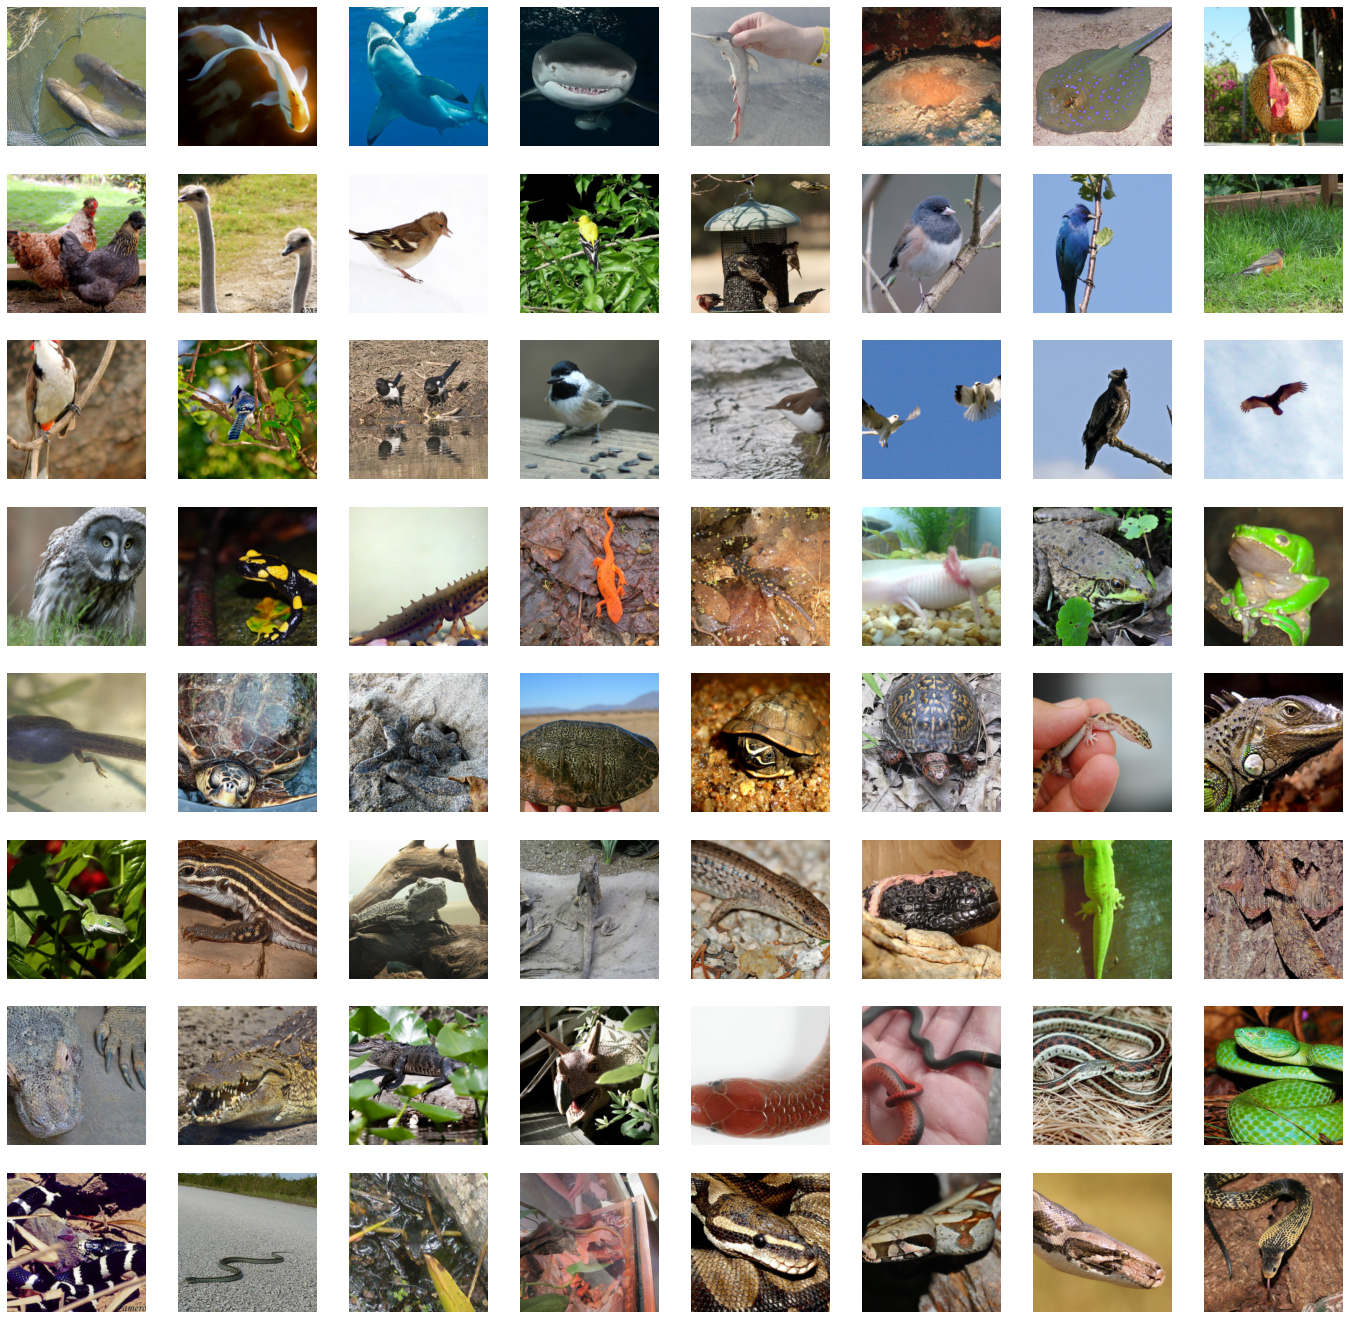

In [7]:
user.plot(true_user_data)

# 重构用户数据：
现在我们发起攻击，只根据 server_payload 和 shared_data 重构用户数据。

对于这种攻击，我们还与攻击者共享来自恶意服务器的秘密信息（server.secrets），这里是印记模块的位置和结构。

In [8]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 105 hits.


接下来，我们将评估指标，比较重构的用户数据和真实的用户数据。

# 通过直接的 GT 比较去除混合图像

In [9]:
reconstructed = torch.zeros_like(true_user_data["data"])
for sample in reconstructed_user_data["data"]:
        l2_dists = (sample[None] - true_user_data["data"]).pow(2).mean(dim=[1, 2, 3])
        min_dist, min_idx = l2_dists.min(dim=0)
        if min_dist < 1e-1:
            reconstructed[min_idx] = sample
reconstructed_user_data = dict(data=reconstructed, labels=None)

In [ ]:
!pip install kornia

In [ ]:
!pip install pytorch_wavelets

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/root/miniconda3/lib/python3.8/site-packages/breaching/analysis/metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/breaching/analysis/metrics.py:143: UserWarning: To utilize registered PSNR, install kornia.
  warnings.warn("To utilize registered PSNR, install kornia.")


And finally, we also plot the reconstructed data:

In [ ]:
user.plot(reconstructed_user_data)